## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.75]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0729 13:27:27.258902  7628 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 13:27:27.259900  7628 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 13:27:27.261895  7628 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 13:27:27.333703  7628 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0729 13:27:27.569407  7628 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0729 13:27:27.577385  7628 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0729 13:27:27.664729  7628 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 4s 74us/step - loss: 1.3695 - acc: 0.5235 - val_loss: 1.5452 - val_acc: 0.4534
Epoch 14/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.3503 - acc: 0.5338 - val_loss: 1.5336 - val_acc: 0.4594
Epoch 15/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.3311 - acc: 0.5390 - val_loss: 1.5294 - val_acc: 0.4618
Epoch 16/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.3120 - acc: 0.5465 - val_loss: 1.5229 - val_acc: 0.4641
Epoch 17/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.2947 - acc: 0.5519 - val_loss: 1.5176 - val_acc: 0.4694
Epoch 18/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2777 - acc: 0.5577 - val_loss: 1.5133 - val_acc: 0.4696
Epoch 19/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2603 - acc: 0.5654 - val_loss: 1.5079 - val_acc: 0.4721
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 5s 94us/step - loss: 2.3974 - acc: 0.2269 - val_loss: 2.2349 - val_acc: 0.2816
Epoch 2/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.8785 - acc: 0.3515 - val_loss: 1.9166 - val_acc: 0.3495
Epoch 3/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.7373 - acc: 0.3912 - val_loss: 1.7899 - val_acc: 0.3787
Epoch 4/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.6617 - acc: 0.4192 - val_loss: 1.7286 - val_acc: 0.3964
Epoch 5/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.6059 - acc: 0.4371 - val_loss: 1.6755 - val_acc: 0.4138
Epoch 6/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.5630 - acc: 0.4531 - val_loss: 1.6458 - val_acc: 0.4250
Epoch 7/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.5268 - acc: 0.4648 - val_loss: 1.6305 - val_acc: 0.4298
Epoch 8/25
50000/50000 [============================

Epoch 23/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.4601 - acc: 0.8666 - val_loss: 1.5494 - val_acc: 0.5170
Epoch 24/25
50000/50000 [==============================] - 4s 85us/step - loss: 0.4437 - acc: 0.8738 - val_loss: 1.5548 - val_acc: 0.5197
Epoch 25/25
50000/50000 [==============================] - 4s 86us/step - loss: 0.4313 - acc: 0.8785 - val_loss: 1.5454 - val_acc: 0.5244
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________

50000/50000 [==============================] - 5s 90us/step - loss: 1.1031 - acc: 0.6254 - val_loss: 1.4924 - val_acc: 0.4802
Epoch 11/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.0738 - acc: 0.6373 - val_loss: 1.4745 - val_acc: 0.4881
Epoch 12/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.0462 - acc: 0.6467 - val_loss: 1.4454 - val_acc: 0.4936
Epoch 13/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.0181 - acc: 0.6569 - val_loss: 1.4524 - val_acc: 0.4952
Epoch 14/25
50000/50000 [==============================] - 5s 98us/step - loss: 0.9921 - acc: 0.6692 - val_loss: 1.4527 - val_acc: 0.4934
Epoch 15/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.9683 - acc: 0.6779 - val_loss: 1.4544 - val_acc: 0.4965
Epoch 16/25
50000/50000 [==============================] - 4s 87us/step - loss: 0.9445 - acc: 0.6859 - val_loss: 1.4462 - val_acc: 0.4990
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.8087 - acc: 0.3705 - val_loss: 2.2377 - val_acc: 0.2984
Epoch 2/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.5426 - acc: 0.4541 - val_loss: 2.2036 - val_acc: 0.2691
Epoch 3/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.4402 - acc: 0.4909 - val_loss: 2.2474 - val_acc: 0.2642
Epoch 4/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.3611 - acc: 0.5190 - val_loss: 1.8980 - val_acc: 0.3354
Epoch 5/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.2991 - acc: 0.5424 - val_loss: 2.0269 - val_acc: 0.3216
Epoch 6/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.2500 - acc: 0.5600 - val_loss: 1.8523 - val_acc: 0.3544
Epoch 7/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.2072 - acc: 0.5727 - val_loss: 1.7672 - val_

Epoch 23/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.7045 - acc: 0.7659 - val_loss: 1.8989 - val_acc: 0.4240
Epoch 24/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.6773 - acc: 0.7752 - val_loss: 1.8931 - val_acc: 0.4323
Epoch 25/25
50000/50000 [==============================] - 4s 86us/step - loss: 0.6511 - acc: 0.7872 - val_loss: 1.8877 - val_acc: 0.4269
Numbers of exp: 10, reduce_factor: 0.75, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________

Epoch 9/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.1767 - acc: 0.5930 - val_loss: 1.6231 - val_acc: 0.4377
Epoch 10/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.1361 - acc: 0.6075 - val_loss: 1.5887 - val_acc: 0.4472
Epoch 11/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.1040 - acc: 0.6201 - val_loss: 1.8007 - val_acc: 0.4091
Epoch 12/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.0706 - acc: 0.6354 - val_loss: 1.4906 - val_acc: 0.4832
Epoch 13/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.0400 - acc: 0.6477 - val_loss: 1.5828 - val_acc: 0.4532
Epoch 14/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.0086 - acc: 0.6572 - val_loss: 1.6787 - val_acc: 0.4385
Epoch 15/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.9811 - acc: 0.6691 - val_loss: 1.7282 - val_acc: 0.4291
Epoch 16/25
50000/50000 [==========

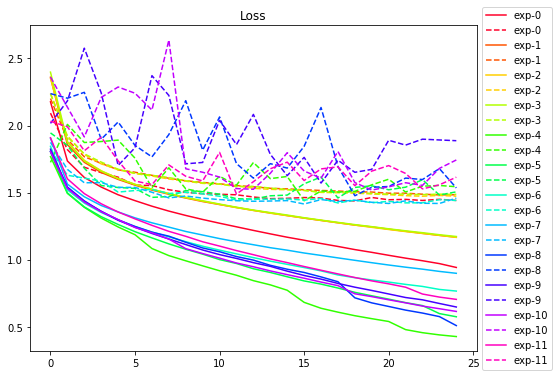

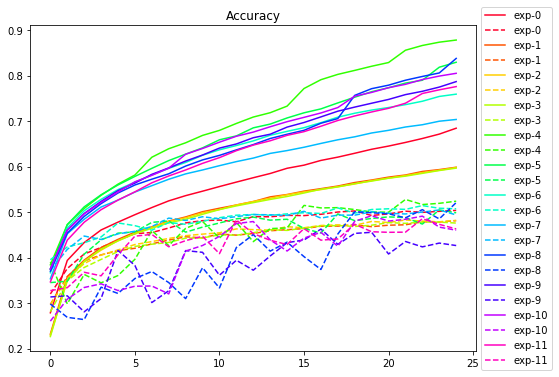

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()